# Robust Angular Diameters in Python (`RADPy`)

## Introduction to `RADPy`

`RADPy` stands for Robust Angular Diameters in Python. This was created to allow for multi-wavelength fits for angular diameters of stars measured with interferometric methods. Currently `RADPy` only has compatibility with the instruments on the Center for High Angular Resolution Astronomy (CHARA) Array. `RADPy` is currently configured for the following instruments at CHARA:

- Classic/CLIMB
- PAVO
- VEGA
- MIRC-X (in progress)

The remaining CHARA instruments SPICA and MYSTIC will be integrated soon.

## What does `RADPy` actually do?
`RADPy` accepts data from an arbitrary number of beam-combiners from CHARA and allows the user to fit for the angular diameters (both uniform disk and limb-darkened disk) of single stars. With the fitted angular diameter, the user can also calculate the remaining fundamental stellar parameters of effective temperature, stellar luminosity, and radius of the measured star. The user can also plot the interferometric data with the chosen angular diameter fit (uniform or limb-darkened) which will output a publication ready plot. The plotting is highly customizable to the user's needs, including the type of model plotted, the ability to add the diameter in text to said plot, the binning of the data if the user choses to, and more. 

The core of `RADPy` is a Monte Carlo simulation that involves a custom-built bracket bootstrapping within. A bracket in the realm of interferometry describes a set of data taken at the same time. Several instruments at CHARA span a wavelength range, so for every one observation, there is a span of data points to cover the wavelength ranges. `RADPy` automatically assigns a bracket number to the data once the data files are read in. The bracket numbers are assigned based on time-stamp and for PAVO, based on the same UCOORD and VCOORD measurements (as PAVO data does not output a time stamp). 

For uniform disk diameters, `RADPy` will sample the wavelength of observations on a normal distribution. Within the bracket bootstrapping, the visibilities of each bracket chosen to be fit are sampled on a normal distribution. Using lmfit, the data are then fit using the uniform disk visibility squared equation. The final output results in a list of angular diameters calculated. The final uniform disk diameter is determined by taking the average of the uniform disk diameters and the error is determined by taking the mean absolute deviation. 

For limb-darkened disk diameters, `RADPy` follows a similar structure to the uniform disk diameters. There are a few differences which I'll highlight below:

- One needs the limb-darkening coefficient. To account for the limb-darkening coefficient, the tables of limb-darkening coefficients determined by Claret et al. 2011 are used. Based on the observation band, surface gravity (log g), and the effective temperature (Teff) of the star, `RADPy` will use an interpolated function based on the Claret tables to calculate the limb-darkening coefficient. If the effective temperature is less than 3500 and the surface gravity is between 3.5 and 5, the tables with the PHOENIX models are used. For all other stars, the tables with the ATLAS models are used.
- For each iteration of the MC, `RADPy` calculates a limb-darkening coefficient for each band used (i.e. R-band). Within the bootstrapping, `RADPy` samples the limb-darkening coefficient on a normal distribution using 0.02 has the "error". The limb-darkening coefficient is then used in the full visibility squared equation and the limb-darkened angular diameter is fit.
- To ensure `RADPy` is fitting for the optimal angular diameter, the limb-darkened disk fitting function will iterate until minimal change between the previous angular diameter and the one just calculated is seen. For robustness, the effective temperature is also checked as well. Minimal change is defined as being less than or equal to 0.05% difference.

## What is in this notebook?

This tutorial is designed to show the general steps of how a user should implement `RADPy` for your own angular diameter fitting needs. This notebook will go over how to install, how to import the necessary modules from `RADPy`, how to read in your data, how to perform initial fits, how to run the Monte Carlo simulations, how to calculate the remaining stellar parameters, and how to generate publicaiton ready plots. 

## Usage

If you do use this package, please use the following citation:

## Contact
- Ashley Elliott (aelli76@lsu.edu)

## Resources
Link to the github repository (currently private but will be made public soon once documentation is finished): <https://github.com/spaceashley/radpy>


## To install:

**Please pay careful attention to this!!**

Simply use pip to install `RADPy`. Due to naming conflicts, to install `RADPy`, you must use "rsadpy". 

`pip install rsadpy`

The installation should also install all necessary additional packages you need to run everything. Just in case, here is a list of all the necessary packages that aren't default:
- `lmfit`
- `astropy`
- `astroquery`
- `gaiadr3-zeropoint`

To test if the installation worked, import RADPy. If you did not get an error, you should be all set. 

`import radpy`

NOTE: 

to _install_, use rsadpy. 

to _import_, use radpy

In [ ]:
#pip install rsadpy

In [ ]:
#import radpy

## Step 1: Getting the data set-up for use
Now that you've installed `RADPy`, first step is to read in your data files.

`RADPy` accepts .txt, .fits, .csv, and .oifits.

Your first step is to import all modules from `radpy.datareadandformat` using the "*". 


In [1]:
from radpy.datareadandformat import *

Next step is to set your file path. In the example below, I'm setting the file path for three different instruments.

In [ ]:
filenamec = "C:\\Users\\oxfor\\Research\\rsadpy\\radpy\\data\\ClassicData.csv"
filenamep = "C:\\Users\\oxfor\\Research\\rsadpy\\radpy\\data\\PAVOdata.csv"
filenamev = "C:\\Users\\oxfor\\Research\\rsadpy\\radpy\\data\\Vegadata.csv"

In [2]:
filename = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\output_184499.txt"

In [3]:
data, num_brack = filename_extension(filename, 'P', verbose = True)

Header detected: ['B/lambda', 'V2', 'sigma_V2', 'U(meters)', 'V(meters)']
Number of brackets: 16


In [ ]:
data

Next, we want to use the function `filename_extension()`. 
The two inputs will be your filepath you just set above and then an indicator for which instrument the data are from. 
Here are the list of acceptable inficators:
- 'C' for Classic.
- 'V' for VEGA
- 'P' for PAVO
- 'M' for MIRC-X
- 'My' for MYSTIC
- 'S' for SPICA

In [ ]:
#datav, num_brack_v = filename_extension(filenamev, 'V')
#datac, num_brack_c = filename_extension(filenamec, 'C')
#datap, num_brack_p = filename_extension(filenamep, 'P')
data, num_brack = filename_extension(filename, 'P', verbose = True)

Our next step is to convert the data into an `InterferometryData` object. This object will allow for ease of use through the fitting. 
There is an object name for each instrument (so far). 

Below is the syntax:

PAVO - `PavoData(data)`

VEGA - `VegaData(data)`

Classic - `ClassicData(data)`

MIRCX - `MircxData(data)`

The "data" will be the output of the `filename_extension` function you called in the previous step. 


In [6]:
pavo_data = PavoData(data)
pavo_df = pavo_data.make_df()
#vega_data = VegaData(datav)
#classic_data = ClassicData(datac)

The last step to complete for getting the data ready to use is to combine all your data into one. RADPy is a combined fit so we need to of course combine the data. To do this, use the function `combined()`. 

The inputs for this function will be the data you would like to combine. So for the purposes of this tutorial, we are combining three data sets, PAVO, VEGA, and Classic. One key step here is to use the `InterferometryDataObject`'s attribute `make_df()`. This will convert your data into a pandas dataframe for use.


In [ ]:
b, v2, dv2, wave, band, brack, inst = combined(pavo_data.make_df(), classic_data.make_df(), vega_data.make_df())
spf = b/wave

In [9]:

b, v2, dv2, wave, band, brack, inst = combined(pavo_data.make_df())
spf = b/wave

In the above cell, **combined** will return the baseline, visibility squared, error on the visibility squared, the wavelength of each measurement, the bandwidth for each measurement, the bracket assigned to each measurement, and the instrument each data point is associated with. 

We also calculate the spatial frequency for use later (mainly for plotting) by dividing the baseline by the wavelength. 

## Step 2: Creating a Stellar Params object
Aside from the data, the only other information needed for the fits to run are additional stellar parameters for your target. 

You need the following:
| Parameter        | Unit          |
| ------------- |:-------------:| 
| Bolometric Flux     | 10^-8 ergs/s/cm^2  |
| Error on Bolometric Flux     | 10^-8 ergs/s/cm^2     |
| [Fe/H] | dex      |
| Error on [Fe/H] | dex |
| Surface gravity (log g) | dex |
|Error on surface gravity (log g) | dex |

`RADPy` has a class named `StellarParams()`. This class will store all of your stellar parameters throughout the notebook. 

To create a `StellarParams()` object, first we need to import: `from radpy.stellar import *`


In [11]:
from radpy.stellar import *

To create the object, simply call the object: `StellarParams()`. 

In [12]:
star = StellarParams()

We have now created a `StellarParams()` object. To see the contents of the object, just type out the name you called it. For this tutorial, I've named it `star`. You should be able to see all the parameters it has as a default, then there should be a `None` and then the associated unit with each variable. The `None` is there because we have yet to fill the object with any parameters. 

In [ ]:
star

Alright, lets add some parameters. 

To add parameters to your `StellarParams()` object, the syntax is: "object name"."parameter name". 
So for example, if I wanted to add the bolometric flux of my star to my object, I would say `star.fbol`. 

Lets go ahead and add my stellar parameters. 

In [ ]:
#Stellar parameters
p = 152.864
dp = 0.0494
f = 21.751
df = 0.585
logg = 4.5
dlogg = 0.1
m = 0.09
dm = 0.08

star.fbol = f
star.fbol_err = df
star.logg = logg
star.logg_err = dlogg
star.feh = m
star.feh_err = dm
star.plx = p
star.plx_err = dp

In [15]:
#Stellar parameters
f = 6.2
df = (6.2)*(0.05)
logg = 4.1
dlogg = 0.1
m = -0.6
dm = 0.1

star.fbol = f
star.fbol_err = df
star.logg = logg
star.logg_err = dlogg
star.feh = m
star.feh_err = dm


Great! Let's take a look at the object to make sure that it worked. 

In [16]:
star

fbol = 6.2 [10⁻⁸ erg/s/cm²]
fbol_err = 0.31000000000000005 [10⁻⁸ erg/s/cm²]
logg = 4.1 [dex]
logg_err = 0.1 [dex]
feh = -0.6 [dex]
feh_err = 0.1 [dex]
plx = None [mas]
plx_err = None [mas]
dist = None [pc]
dist_err = None [pc]
udthetai = None [mas]
udthetai_err = None [mas]
ldthetai = None [mas]
ldthetai_err = None [mas]
udtheta = None [mas]
udtheta_err = None [mas]
ldtheta = None [mas]
ldtheta_err = None [mas]
teff = None [K]
teff_err = None [K]
lum = None [L☉]
lum_err = None [L☉]
rad = None [R☉]
rad_err = None [R☉]
ldc_R = None [ ]
ldc_K = None [ ]
ldc_H = None [ ]
ldc_J = None [ ]

Next step is to calculate the distance. To do this, we call the `distances` function. This function will calculate the distance of your star using the parallax that you provided, or if no parallax is provided, will get the parallax for you using Gaia or Hipparcos. If you use Gaia, RADPy will apply the zero-point correction to your parallax, as described in <insert paper here>. If you use Hipparcos, no zero-point correction will be applied. The default is to use Gaia.

Here are some example usages of the `distances` function for a variety of scenarios:

Have your own parallax and it came from Gaia?: `D, dD = distances('object ID', plx = p, dplx = dp)`

Have your own parallax and it came from Hipparcos?: `D, dD = distances('object ID', plx = p, dplx = dp, use_Hipp = True)`

Don't have your own parallax and you want to use Gaia?: `D, dD = distances('object ID')`

Don't have your own parallax and you want to use Hipparcos?: `D, dD = distances('object ID', use_Hipp = True)`

If you would like to see where RADPy is getting your parallax from, set "verbose" = True. This will print out where it found the parallax. It will also print out the zero-point corrected parallax and the calculated distance. 

NOTE: A warning may appear saying something similar to "UserWarning: The apparent magnitude of one or more of the sources is outside the expected range      (6-21 mag)." This is fine. This is an error from `gaiadr3-zeropoint`. If your star is within the Gaia magnitude range (stars brighter than Gmag = 3),    use Hipparcos. 



In [17]:
D, dD = distances('HD 184499', verbose = True)
star.dist = D
star.dist_err = dD

Found Gaia DR3: Gaia DR3 2045599984313800448
Source ID 2045599984313800448
Corrected parallax: 31.39
Distance: 31.85892 +/- 0.01678 [pc]


In [ ]:
star

## Step 3: Initial fits

Now we have our stellar parameters set up and our data read in and formatted like needed. Now lets start our fits. 

The first step for the fitting is to perform an initial fit for the uniform disk diameter and then for the limb-darkened disk diameter. 

We need to first import: `from radpy.LDfitting import initial_LDfit` and `from radpy.UDfitting import initial_UDfit`

Next, we can run the initial uniform disk diameter fit using the function `initial_UDfit()`. 

The inputs to `initial_UDfit()' include:
- spf: spatial frequency
- v2: the visibility squared data
- dv2: the error on the visibility squared data
- initial_guess: an initial guess on the diameter
- star: your `StellarParams()` object
- verbose: default is set to False. If True, will print out the initial fit report from `lmfit`



In [18]:
from radpy.LDfitting import initial_LDfit
from radpy.UDfitting import initial_UDfit

In [19]:
theta1, dtheta1, chisqr1 = initial_UDfit(spf, v2, dv2, 0.4, star, verbose = True)


Initial fit with lmfit:
[[Model]]
    Model(UDV2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 352
    # variables        = 1
    chi-square         = 353.775770
    reduced chi-square = 1.00790818
    Akaike info crit   = 3.77130608
    Bayesian info crit = 7.63493725
    R-squared          = -25.6325467
[[Variables]]
    theta:  0.38379149 +/- 0.00110746 (0.29%) (init = 0.4)


Next, our limb-darkened disk initial fit, using `initial_LDfit()`.

The inputs for `initial_LDfit()` are:
- spf: spatial frequency
- v2: visibility squared data
- dv2: the error
- star: your `StellarParams()` object
- filt: the filter in which you want to perform the initial fit in. Options include 'R', 'H', 'K', or 'J'.
- verbose: default is set to False. If True, will print out the results of the initial fit from `lmfit`.

In [20]:
theta2, dtheta2, chisqr2 = initial_LDfit(spf, v2, dv2, star, 'R', verbose = True)

Effective temperature: 5962.83111158608 +/- 75.0325135143018 K
LDC for filter  R : 0.5250313919589626
Initial fit with lmfit:
[[Model]]
    Model(V2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 352
    # variables        = 1
    chi-square         = 351.510971
    reduced chi-square = 1.00145576
    Akaike info crit   = 1.51063075
    Bayesian info crit = 5.37426193
    R-squared          = -25.4620506
[[Variables]]
    theta:  0.40270512 +/- 0.00117175 (0.29%) (init = 0.38379)


Both `initial_UDfit()` and `initial_LDfit()` automatically update the `StellarParams()` object with the initial results. 

In [21]:
star

fbol = 6.2 [10⁻⁸ erg/s/cm²]
fbol_err = 0.31000000000000005 [10⁻⁸ erg/s/cm²]
logg = 4.1 [dex]
logg_err = 0.1 [dex]
feh = -0.6 [dex]
feh_err = 0.1 [dex]
plx = None [mas]
plx_err = None [mas]
dist = 31.85892 [pc]
dist_err = 0.01678 [pc]
udthetai = 0.38379 [mas]
udthetai_err = 0.00111 [mas]
ldthetai = 0.40271 [mas]
ldthetai_err = 0.00117 [mas]
udtheta = None [mas]
udtheta_err = None [mas]
ldtheta = None [mas]
ldtheta_err = None [mas]
teff = 5962.83111 [K]
teff_err = 75.03251 [K]
lum = None [L☉]
lum_err = None [L☉]
rad = None [R☉]
rad_err = None [R☉]
ldc_R = None [ ]
ldc_K = None [ ]
ldc_H = None [ ]
ldc_J = None [ ]

## Step 4: Running the fits

Now that we have the initial fits done, we can now start the Monte Carlo simulations.

First step is the uniform disk diameter fit. 

We need to first import the functions: `from radpy.UDfitting import run_udmcbs_fit, udfit_values`

To call the Monte Carlo function, we use `run_udmcbs_fit()`. 

The inputs to this function include:
- mc_num: number of Monte Carlo iterations you want
- bs_num: number of bracket bootstrapping iterations you want
- datasets: the datasets you want to fit (i.e. [data1, data2, data3])
- stellar_params: your `StellarParams()` object
- verbose: default is set to False

This function will return a list of uniform disk diameters. 

NOTE: mc_num describes the number of outside loop iterations. bs_num will set the inner loop iterations. This means that if you set mc_num = 5, and bs_num = 5, you will have 5 iterations of the bracket bootstrapping for every one iteration of the mc_num, making it 25 iterations in total. For publication quality results, I recommend minimum mc_num = 71 and bs_num = 71, for 5041 iterations in total. 

In [22]:
from radpy.UDfitting import run_udmcbs_fit, udfit_values

In [25]:
#results = run_udmcbs_fit(10, 10, datasets = [pavo_data, vega_data, classic_data], stellar_params = star)
results = run_udmcbs_fit(71, 71, datasets = [pavo_data], stellar_params = star)

Next, we need to calculate the uniform disk diameter and its error, along with the effective temperature. To do this, we use `udfit_values()`. This function will return the averaged uniform disk diameter, the error on said diameter, the chi-squared value of the fit, the chi-squared reduced value of the fit, and the effective temperature calculated using the diameter you just determined. 

The inputs to `udfit_values()`:
- spf: spatial frequency
- v2: the visibility squared
- dv2: the error on the visibility squared
- results: the results of `run_udmcbs_fit()`
- stellar_params: the `StellarParams()` object
- verbose: default is False. if set to True, will print out your results

This function will also automatically update your `StellarParams()` object with the uniform disk angular diameter and error calculated as well as with the effective temperature. 

In [26]:
udfit_values(spf, v2, dv2, results, stellar_params = star, verbose = True)

Uniform Disk Diameter after MC/BS: 0.3841 +/- 0.00392 mas
Chi-squared: 7.590418952166848
Chi-squared reduced: 0.021625125219848572
Temperature: 5960.7 +/- 80.5 K


In [ ]:
star

Now time for the limb-darkened disk fit.

We need to first import the functions: `from radpy.LDfitting import run_LDfit`

To call the Monte Carlo function, we use `run_LDfit()`. 

The inputs to this function include:
- mc_num: number of Monte Carlo iterations you want
- bs_num: number of bracket bootstrapping iterations you want
- ogdata: the original datasets you have (i.e. [odgata1, ogdata2,ogdata3])
- datasets: the datasets you want to fit (i.e. [data1, data2, data3])
- stellar_params: your `StellarParams()` object
- verbose: default is set to False. If set to True, it will print out the results of the loop. 

This function will return the final limb-darkened angular diameter and its error, the final effective temeperature and its error, the limb-darkening coefficients for each band and the chi-squared values. The verbose print statement will display how many iterations it took to find minimal changes, the limb-darkened disk diameter and its error, the limb-darkening coefficients for each wavelength, the chi square value for each LDC, te chi square reduced value for each LDC, the effective temperature and its error, and the percent differences for the last iterations. 

This function will also automatically update the `StellarParams()` object with your final values. 

NOTE: mc_num describes the number of outside loop iterations. bs_num will set the inner loop iterations. This means that if you set mc_num = 5, and bs_num = 5, you will have 5 iterations of the bracket bootstrapping for every one iteration of the mc_num, making it 25 iterations in total. For publication quality results, I recommend minimum mc_num = 71 and bs_num = 71, for 5041 iterations in total. 

NOTE: The larger the numbers for mc_num and bs_num, the longer the fit will take. It should hopefully not take longer than 5-10 minutes.

In [ ]:
from radpy.LDfitting import run_LDfit

In [ ]:
thetaf, dthetaf, tf, dtf, ldcsf, chisf = run_LDfit(2, 2, ogdata = [spf, v2, dv2], datasets = [pavo_data, vega_data, classic_data], stellar_params = star, verbose = True)

In [ ]:
star

## Step 5: Remaining Stellar Parameters

After we calculate the limb-darkened disk angular diameter and effective temperature, we can now calculate the radius of the star and the luminosity using the function `calc_star_params()`.

The inputs are:
- stellar_params: your `StellarParams()` object
- verbose: default is False, if set to True, will print out the remaining stellar parameters to the screen

This function will also automatically update your `StellarParams()` object with the parameters. 

In [ ]:
calc_star_params(star, verbose = True)

In [ ]:
star

## Step 6: Plotting your data and the fit

To plot the data and your fit(s), we will use the function `plot_vs_fit()`. This function allows the user to customize the plot to their liking. 

First we need to import the module: `from radpy.plotting import plot_v2_fit`

We then need to created a dictionary of the data you would like to plot. This is just to make it easier for the function to plot the different datasets separately, with their own markers, colors, and labels. 

`data_dict = {'pavo':pavo_data, 'vega':vega_data, 'classic':classic_data}`

The inputs to `plot_v2_fit()` are:
- data_dict: the data dictionary of the original data
- star: your `StellarParams()` object
- line_spf: the range of spatial frequencies you want your model to span (i.e. `line_spf = np.linspace(0.00001, 2.5e8, 1000)`, must not start with 0 otherwise it will return an error
- set_axis: sets your axis ranges (i.e. `set_axis = [xmin, xmax, ymin, ymax]`)
- ldc_band: options are 'ldc_R', 'ldc_H', ldc_K', or 'ldc_J'. If plotting the uniform disk diameter fit, do not set
- datasets_to_plot: the datasets you would like plotted (i.e. datasets_to_plot = `['pavo', 'vega', 'classic']`)
- plot_udmodel: if set to True, will plot the uniform disk diameter fit
- plot_ldmodel: if set to True, will plot the limb-darkened disk diameter fit with the LDC in the band indicated above
- to_bin: if you would like any of your data binned, tell it which data set (i.e. `to_bin = ['pavo']`)
- eq_text: if set to True, will annotate your plot with the angular diameter (either uniform or limb-darkened)
- savefig: if you would like to save your figure, give it the name of the file you would like to call it (i.e. `eq_text = 'V2Plot.jpg'`)
- showfig: default is True but just ensures the figure will show to your screen


In [27]:
from radpy.plotting import plot_v2_fit

In [28]:
#data_dict = {'pavo':pavo_data, 'vega':vega_data, 'classic':classic_data}
data_dict = {'pavo':pavo_data}

### Here are some examples of the types of plots that can be made:

Example 1: Uniform disk fit with the PAVO, VEGA, and Classic data being plotted, the PAVO data are being binned, and I want the diameter to be annotated to the plot

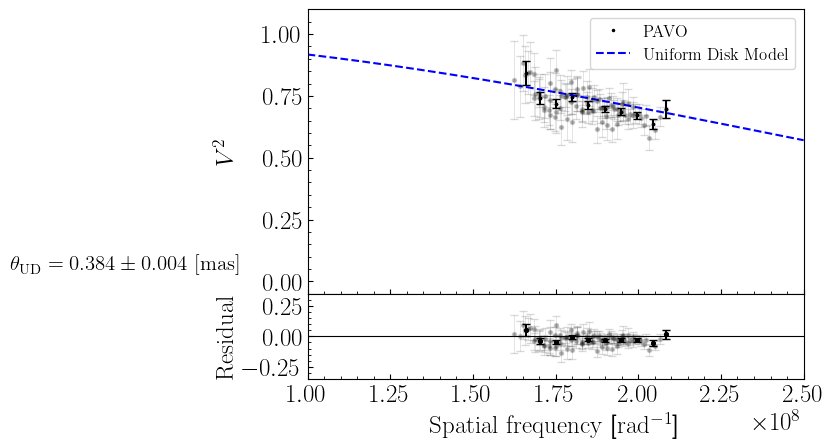

(<Figure size 640x480 with 2 Axes>,
 (<Axes: ylabel='$V^2$'>,
  <Axes: xlabel='$\\rm Spatial$ $\\rm frequency$ [$\\rm rad^{-1}$]', ylabel='$\\rm Residual$'>))

In [30]:
plot_v2_fit(
    data_dict=data_dict,
    star=star,       
    line_spf=np.linspace(1e8, 2.5e8, 1000),
    set_axis = [1e8, 2.5e8, -0.05,1.1],   
    datasets_to_plot=['pavo'],
    plot_udmodel = True,
    to_bin = ['pavo'],
    eq_text=True,
    show = True
)

Example 2: Limb-darkened disk fit
Here I want to plot the limb-darkened disk fit in the 'R' band. I want all three data sets, and I want the PAVO data binned. I also want to annotate the diameter to the plot.

In [ ]:
plot_v2_fit(
    data_dict=data_dict,
    star=star,       
    line_spf=np.linspace(0.00001, 2.5e8, 1000),
    set_axis = [0, 2.5e8, -0.05,1.1],
    ldc_band='ldc_R',      
    datasets_to_plot=['pavo', 'vega', 'classic'],
    plot_ldmodel = True,
    to_bin = ['pavo'],
    eq_text=True,
    show = True
)

Example 3:

Here I want to plot the limb-darkened disk fit for the K band and I don't want to annotate the diameter to the plot. I also don't want any data binned.

In [ ]:
plot_v2_fit(
    data_dict=data_dict,
    star=star,         
    line_spf=np.linspace(0.00001, 2.5e8, 1000),
    set_axis = [0, 2.5e8, -0.05,1.1],
    ldc_band='ldc_K',     
    datasets_to_plot=['pavo', 'vega', 'classic'],
    plot_ldmodel = True,
    eq_text=True,
    show = True
)

Here is the full import statement block for all the things needed for this script:

In [ ]:
from radpy.stellar import *
from radpy.datareadandformat import *
from radpy.plotting import plot_v2_fit
from radpy.LDfitting import initial_LDfit, run_LDfit
from radpy.UDfitting import initial_UDfit, run_udmcbs_fit, udfit_values